In [1]:
import torch
import timm
from timm import utils
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.cuda
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\ameyd\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

In [3]:
model = 'inception_next_small'

In [4]:
model = timm.create_model(model, pretrained=True)

In [5]:
#Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [6]:
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)

np.random.seed(seed)
utils.random_seed(seed, 0)
torch.manual_seed(seed)

In [7]:
model.head.fc2 = nn.Linear(in_features=2304, out_features=1, bias=True)

In [72]:
print(model)

MetaNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): Sequential(
    (0): MetaNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): MetaNeXtBlock(
          (token_mixer): InceptionDWConv2d(
            (dwconv_hw): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
            (dwconv_w): Conv2d(12, 12, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5), groups=12)
            (dwconv_h): Conv2d(12, 12, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0), groups=12)
          )
          (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (mlp): ConvMlp(
            (fc1): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
            (norm): Identity()
            (act): GELU(approximate='none')
            (drop): Dropout(p=0.0, inplace=False)
 

In [8]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Define a transformation to resize and normalize your images
# Define a transformation to resize and normalize your grayscale images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust to your model's input size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Mean and std for grayscale images
])

In [2]:
import pandas as pd

In [3]:
imageData=pd.read_csv('../../data/siim-acr-pneumothorax/stage_1_train_images.csv')

In [4]:
imageData

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
...,...,...,...
10670,10670_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32459.15178751...,1
10671,10671_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,1
10672,10672_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.32730.15178751...,0
10673,10673_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.13252.15178752...,0


In [5]:
type(imageData['has_pneumo'])

pandas.core.series.Series

In [6]:
label_counts = imageData['has_pneumo'].value_counts()

In [7]:
label_counts

0    8296
1    2379
Name: has_pneumo, dtype: int64

In [23]:
minority_class = label_counts.idxmin()
minority_class_count = label_counts.min()

In [24]:
minority_class_count

2379

In [26]:
majority_data = imageData[imageData['has_pneumo'] == 0]
minority_data = imageData[imageData['has_pneumo'] == 1]

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
)

In [29]:
augmentation_factor = int((label_counts.max() - minority_class_count) / minority_class_count)

In [41]:
augmented_images = []
for i in range(augmentation_factor):
    for index, row in minority_data.iterrows():
        filename = row['new_filename']
        img_path = '../../data/siim-acr-pneumothorax/png_images/' + filename  # Adjust the path to your image directory
        img = cv2.imread(img_path)

        if img is not None:
            # Add the channel dimension to the image
            img = img.reshape((1,) + img.shape)

        # Generate augmented images
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append({'new_filename': filename, 'has_pneumo': 1})
            break  # Make sure to break after generating one augmented image per original image

# Combine the original majority class data with the augmented minority class data
augmented_data = majority_data.append(pd.DataFrame(augmented_images))

C:\Users\ameyd\AppData\Local\Temp\ipykernel_15864\3754601853.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = majority_data.append(pd.DataFrame(augmented_images))


In [42]:
print(augmented_data['has_pneumo'].value_counts())

0    8296
1    4758
Name: has_pneumo, dtype: int64


In [79]:
# Apply random undersampling
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(imageData, imageData['has_pneumo'])

In [80]:
len(X_resampled)

4758

In [81]:
y_resampled.value_counts()

0    2379
1    2379
Name: has_pneumo, dtype: int64

In [16]:
#Test the model output

In [8]:
in_features = model.head.fc1.in_features

In [9]:
in_features

768

In [12]:
model.head.fc1 = nn.Linear(in_features, 1)

In [13]:
model.head.fc1 = nn.Linear(in_features, 1)  # Change 1 to the desired number of output units for binary classification
model.head.fc2 = None  # Remove the existing fc2 layer
model.head.act = None  # Remove the existing activation function
model.head.norm = None  # Remove the existing normalization layer
model.head.drop = None  # Remove the existing dropout layer

In [14]:
model.head = nn.Sequential(model.head, nn.Sigmoid())

In [26]:
model.head

Sequential(
  (0): MlpClassifierHead(
    (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
    (fc1): Linear(in_features=768, out_features=1, bias=True)
    (act): None
    (norm): None
    (fc2): None
    (drop): None
  )
  (1): Sigmoid()
)

In [17]:
import os

data_dir = './img'
image_filenames = os.listdir(data_dir)  # List of image file names in your data directory

In [18]:
image_filenames = os.listdir(data_dir)

In [19]:
image = Image.open(image_filenames[0]).convert("RGB")
if transform:
    image = transform(image).unsqueeze(0)

In [32]:
in_features = model.head.fc1.in_features
model.head.fc1 = nn.Linear(in_features, 1)  # Change 1 to the desired number of output units for binary classification
model.head.fc2 = None  # Remove the existing fc2 layer
model.head.act = nn.Sigmoid()  # Remove the existing activation function
model.head.norm = None  # Remove the existing normalization layer
model.head.drop = None  # Remove the existing dropout layer

# Add a sigmoid activation after the linear layer
model.head = nn.Sequential(model.head, nn.Sigmoid())

AttributeError: 'Sequential' object has no attribute 'fc1'

In [20]:
with torch.no_grad():
    output = model(image)

In [21]:
output

tensor([[-0.1408]])

In [74]:
probabilities = torch.sigmoid(output)

In [76]:
probabilities_np = probabilities.cpu().numpy()

In [77]:
probabilities_np

array([[0.1944529 , 0.12688074, 0.47426674, 0.3570304 , 0.43011683,
        0.27928212, 0.3487352 , 0.1443054 , 0.10633117, 0.23080988,
        0.22035547, 0.3930462 , 0.30229175, 0.30200794, 0.29173818,
        0.18936107, 0.42003483, 0.11973131, 0.11265685, 0.31094584,
        0.28104022, 0.20780575, 0.18153124, 0.34598833, 0.07790019,
        0.16849488, 0.19085152, 0.2796657 , 0.24795033, 0.16777332,
        0.1105394 , 0.23386014, 0.18014613, 0.27601987, 0.4657362 ,
        0.23649836, 0.30823064, 0.41483298, 0.24571967, 0.42248505,
        0.36977914, 0.21349762, 0.46984157, 0.48519972, 0.24627115,
        0.43426722, 0.30039585, 0.3290155 , 0.24648905, 0.16743891,
        0.33002606, 0.2480108 , 0.35494632, 0.31827655, 0.04518311,
        0.16257612, 0.14439799, 0.08628424, 0.12917407, 0.23729086,
        0.11803191, 0.2662952 , 0.18444994, 0.48270223, 0.14426611,
        0.17128058, 0.15012835, 0.10359113, 0.18416171, 0.859488  ,
        0.19759932, 0.79381526, 0.17656767, 0.20

In [78]:
probabilities_np.shape

(1, 1000)

In [80]:
for i in probabilities_np[0]:
    print(i)

0.1944529
0.12688074
0.47426674
0.3570304
0.43011683
0.27928212
0.3487352
0.1443054
0.10633117
0.23080988
0.22035547
0.3930462
0.30229175
0.30200794
0.29173818
0.18936107
0.42003483
0.11973131
0.112656854
0.31094584
0.28104022
0.20780575
0.18153124
0.34598833
0.07790019
0.16849488
0.19085152
0.2796657
0.24795033
0.16777332
0.1105394
0.23386014
0.18014613
0.27601987
0.4657362
0.23649836
0.30823064
0.41483298
0.24571967
0.42248505
0.36977914
0.21349762
0.46984157
0.48519972
0.24627115
0.43426722
0.30039585
0.3290155
0.24648905
0.16743891
0.33002606
0.2480108
0.35494632
0.31827655
0.04518311
0.16257612
0.14439799
0.086284235
0.12917407
0.23729086
0.11803191
0.2662952
0.18444994
0.48270223
0.14426611
0.17128058
0.15012835
0.10359113
0.18416171
0.859488
0.19759932
0.79381526
0.17656767
0.20949265
0.20894745
0.25005305
0.45802706
0.26642483
0.39179513
0.3983934
0.19145153
0.12507334
0.15471128
0.2505819
0.28008595
0.1487001
0.19454391
0.44208664
0.3047733
0.39568672
0.28538465
0.37967846
0.4

In [82]:
len(probabilities_np)

1

In [8]:
X = imageData['new_filename'].tolist()

In [11]:
np.asarray(X).shape

(10675,)

In [49]:
#End of test

In [12]:
labels = imageData['has_pneumo']

In [17]:
len(labels)

10675

In [99]:
import os

data_dir = '../../data/siim-acr-pneumothorax/png_images'
image_filenames = os.listdir(data_dir)  # List of image file names in your data directory
image_paths = [os.path.join(data_dir, filename) for filename in image_filenames]

# Make sure image_paths contains the correct file paths to your images
#print(image_paths)

In [100]:
image_paths = []

for i in range(len(X)):
    file_name = '../../data/siim-acr-pneumothorax/png_images/' + X[i]
    image_paths.append(file_name)

In [101]:
image_paths

['../../data/siim-acr-pneumothorax/png_images/0_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/1_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/2_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/3_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/4_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/5_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/6_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/7_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/8_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/9_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/10_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/11_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/12_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/13_train_1_.png',
 '../../data/siim-acr-pneumothorax/png_images/14_train_0_.png',
 '../../data/siim-acr-pneumothorax/png_images/15_t

In [102]:
mask_paths = []

for i in range(len(X)):
    file_name = '../../data/siim-acr-pneumothorax/png_masks/' + X[i]
    mask_paths.append(file_name)

In [103]:
len(mask_paths)

10675

In [104]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [105]:
image = mpimg.imread(image_paths[2])

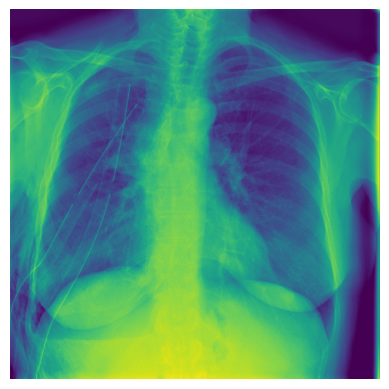

In [106]:
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [107]:
mask = cv2.imread(mask_paths[2], cv2.IMREAD_GRAYSCALE)

In [82]:
if image is not None and mask is not None:
    # Resize the mask to match the image dimensions
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

In [83]:
mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

In [84]:
image = image.astype(float)  # Convert image to float32
mask_colored = mask_colored.astype(float) 

In [108]:
image = np.where( mask == 255, image, np.clip(mask.astype(int) + 50, 0, 255)).astype(np.uint8)

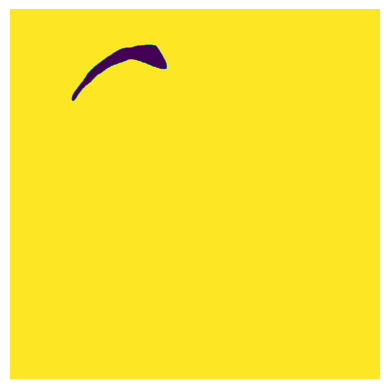

In [109]:
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [20]:
custom_dataset = CustomDataset(image_paths, labels, transform=transform)

In [23]:
from pprint import pprint
pprint(vars(custom_dataset))

{'image_paths': ['../../data/siim-acr-pneumothorax/png_images/0_train_0_.png',
                 '../../data/siim-acr-pneumothorax/png_images/1_train_0_.png',
                 '../../data/siim-acr-pneumothorax/png_images/2_train_1_.png',
                 '../../data/siim-acr-pneumothorax/png_images/3_train_1_.png',
                 '../../data/siim-acr-pneumothorax/png_images/4_train_1_.png',
                 '../../data/siim-acr-pneumothorax/png_images/5_train_0_.png',
                 '../../data/siim-acr-pneumothorax/png_images/6_train_0_.png',
                 '../../data/siim-acr-pneumothorax/png_images/7_train_1_.png',
                 '../../data/siim-acr-pneumothorax/png_images/8_train_1_.png',
                 '../../data/siim-acr-pneumothorax/png_images/9_train_0_.png',
                 '../../data/siim-acr-pneumothorax/png_images/10_train_1_.png',
                 '../../data/siim-acr-pneumothorax/png_images/11_train_1_.png',
                 '../../data/siim-acr-pneumothorax

In [21]:
train_loader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [46]:
num_epochs = 10

In [48]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate and print the average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")

Epoch 1/10:   0%|                                                                                                                                                                       | 0/107 [01:30<?, ?it/s]


KeyboardInterrupt: 

In [13]:
#Testing

In [11]:
imageData=pd.read_csv('../../data/siim-acr-pneumothorax/stage_1_test_images.csv')

In [12]:
imageData

,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
...,...,...,...
1367,1367_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.7049.151787520...,0
1368,1368_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.705.1517875164...,1
1369,1369_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.7050.151787520...,0
1370,1370_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.7051.151787520...,0


In [13]:
label_counts = imageData['has_pneumo'].value_counts()

In [15]:
label_counts

0    1082
1     290
Name: has_pneumo, dtype: int64

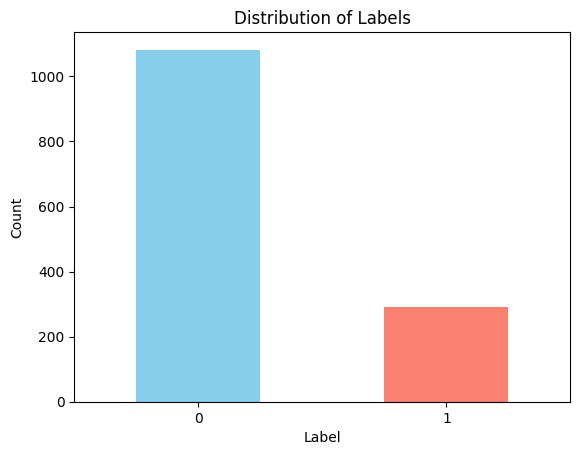

In [14]:
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Optional: rotate x-axis labels for better readability
plt.show()

In [16]:
labels = imageData['has_pneumo']

In [17]:
image_paths = []

for i in range(len(imageData)):
    file_name = '../../data/siim-acr-pneumothorax/png_images/' + imageData['new_filename'][i]
    image_paths.append(file_name)

In [28]:
custom_dataset = CustomDataset(image_paths, labels, transform=transform)

In [29]:
test_loader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [30]:
correct_predictions = 0
total_samples = 0
all_predicted = []
all_labels = []

In [ ]:
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing")::
        #images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = x(images)
        predicted = (outputs > 0.5).float()  # Assuming binary classification
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        #Move the predictions to CPU for processing SciKitLearn
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
accuracy = accuracy_score(all_labels, all_predicted)
f1 = f1_score(all_labels, all_predicted)
conf_matrix = confusion_matrix(all_labels, all_predicted)
mcc = matthews_corrcoef(all_labels, all_predicted)

In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"MCC Score: {mcc:.4f}")